# An Introduction to Federated Learning

Welcome to the Flower federated learning tutorial!

In this notebook, we'll build a federated learning system using Flower and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we continue to federate the PyTorch-based pipeline using Flower.

> Join the Flower community on Slack to connect, ask questions, and get help: [Join Slack](https://flower.dev/join-slack) 🌻 We'd love to hear from you in the `#introductions` channel! If anything is unclear, head over to the `#questions` channel.

Let's get stated!

## Step 0: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

### Installing dependencies

Next, we install the necessary packages for PyTorch (`torch` and `torchvision`) and Flower (`flwr`):

In [2]:
!pip install -q flwr[simulation] torch torchvision matplotlib

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [3]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 1.13.1+cu116 and Flower 1.3.0


It is possible to switch to a runtime that has GPU acceleration enabled (on Google Colab: `Runtime > Change runtime type > Hardware acclerator: GPU > Save`). Note, however, that Google Colab is not always able to offer GPU acceleration. If you see an error related to GPU availability in one of the following sections, consider switching back to CPU-based execution by setting `DEVICE = torch.device("cpu")`. If the runtime has GPU acceleration enabled, you should see the output `Training on cuda`, otherwise it'll say `Training on cpu`.


### Loading the data

Federated learning can be applied to many different types of tasks across different domains. In this tutorial, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. CIFAR-10 can be used to train image classifiers that distinguish between images from ten different classes:

In [4]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations participate in a federation means having ten clients connected to the federated learning server:


In [5]:
NUM_CLIENTS = 10


Let's now load the CIFAR-10 training and test set, partition them into ten smaller datasets (each split into training and validation set), and wrap the resulting partitions by creating a PyTorch `DataLoader` for each of them:

In [6]:
BATCH_SIZE = 32


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


We now have a list of ten training sets and ten validation sets (`trainloaders` and `valloaders`) representing the data of ten different organizations. Each `trainloader`/`valloader` pair contains 4500 training examples and 500 validation examples. There's also a single `testloader` (we did not split the test set). Again, this is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions.

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloaders[0]`) before we move on:

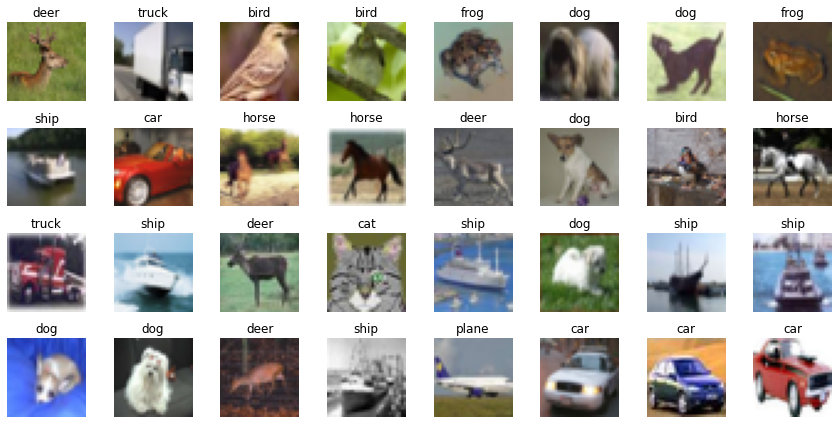

In [7]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

The output above shows a random batch of images from the first `trainloader` in our list of ten `trainloaders`. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

## Step 1: Centralized Training with PyTorch



Next, we're going to use PyTorch to define a simple convolutional neural network. This introduction assumes basic familiarity with PyTorch, so it doesn't cover the PyTorch-related aspects in full detail. If you want to dive deeper into PyTorch, we recommend [*DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ*](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).


### Defining the model

We use the simple CNN described in the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network):

In [8]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)        # 3 input image channel, 6 output channels, 5x5 square convolution
        self.pool = nn.MaxPool2d(2, 2)         # kernel size = 2, stride=2, size of data after this layer: (6,14,14)
        self.conv2 = nn.Conv2d(6, 16, 5)       # 6 input image channel, 16 output channels, 5x5 square convolution
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Applies a linear transformation to the incoming data y = xA^T+b
                                               # size of each input sample: 16*5*5
                                               # size of each output sample: 120
                                               # (1, 120) <-- (1, 16*5*5) * (16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)          # (1, 84) <-- (1, 120) * (120, 84)
        self.fc3 = nn.Linear(84, 10)           # (1, 10) <-- (1, 84) * (84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))  # after conv1 layer  (6,28,28), after pool layer (6,14,14)
        x = self.pool(F.relu(self.conv2(x)))  # after conv2 layer (16,10,10), after pool layer (16,5,5)
        x = x.view(-1, 16 * 5 * 5)            # flatten
        x = F.relu(self.fc1(x))               # after fc1 layer (1, 120)
        x = F.relu(self.fc2(x))               # after fc2 layer (1,84)
        x = self.fc3(x)                       # after fc3 layer (1,10)
        return x

Let's continue with the usual training and test functions:

In [21]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()        # loss function using Cross Entropy
    optimizer = torch.optim.Adam(net.parameters()) # optimizer using Adam (Adaptive Moment Estimation) algorithm
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    y_pred_test = []
    y_true_test = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred_test.append(predicted)
            y_true_test.append(labels)
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy, y_pred_test, y_true_test

### Training the model

We now have all the basic building blocks we need: a dataset, a model, a training function, and a test function. Let's put them together to train the model on the dataset of one of our organizations (`trainloaders[0]`). This simulates the reality of most machine learning projects today: each organization has their own data and trains models only on this internal data: 

In [ ]:
loss_centralized_hist = []  # to contain the loss values of centralized training
acc_centralized_hist = []   # to contain the accuracy values of centralized training

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

In [ ]:
EPOCHS_CEN = 30
for epoch in range(EPOCHS_CEN):
    train(net, trainloader, 1)
    loss, accuracy, _, _ = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
    loss_centralized_hist.append(loss)
    acc_centralized_hist.append(accuracy)

Epoch 1: validation loss 0.06295947861671448, accuracy 0.278
Epoch 2: validation loss 0.059659310817718504, accuracy 0.294
Epoch 3: validation loss 0.05578125715255737, accuracy 0.35
Epoch 4: validation loss 0.054227919340133664, accuracy 0.37
Epoch 5: validation loss 0.05352350425720215, accuracy 0.386
Epoch 6: validation loss 0.05360489201545715, accuracy 0.396
Epoch 7: validation loss 0.05032860565185547, accuracy 0.462
Epoch 8: validation loss 0.04988504791259766, accuracy 0.452
Epoch 9: validation loss 0.04988126564025879, accuracy 0.456
Epoch 10: validation loss 0.04783508253097534, accuracy 0.494
Epoch 11: validation loss 0.04784802603721618, accuracy 0.472
Epoch 12: validation loss 0.04792651975154877, accuracy 0.502
Epoch 13: validation loss 0.049393118143081664, accuracy 0.478
Epoch 14: validation loss 0.04914356470108032, accuracy 0.49
Epoch 15: validation loss 0.049665345549583434, accuracy 0.508
Epoch 16: validation loss 0.049805631399154664, accuracy 0.504
Epoch 17: valid

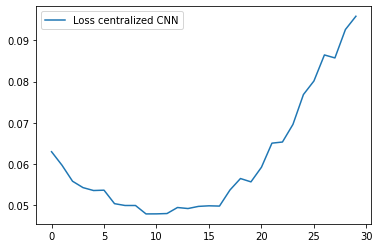

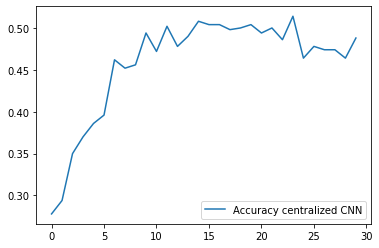

In [ ]:
plt.figure()
plt.plot(np.arange(EPOCHS_CEN), loss_centralized_hist, label="Loss centralized CNN")
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(np.arange(EPOCHS_CEN), acc_centralized_hist, label="Accuracy centralized CNN")
plt.legend(loc='best')
plt.show()

Training the simple CNN on our CIFAR-10 split for 5 epochs should result in a test set accuracy of about 41%, which is not good, but at the same time, it doesn't really matter for the purposes of this tutorial. The intent was just to show a simplistic centralized training pipeline that sets the stage for what comes next - federated learning!

### Test the centralized CNN

In [ ]:
loss, accuracy, y_pred_test, y_true_test = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Final test set performance:
	loss 0.0929153034389019
	accuracy 0.4818


In [ ]:
y_pred_test_list = []
count = 0
for a in y_pred_test:
    for b in a:
        y_pred_test_list.append(b.tolist())

y_true_test_list = []
for a in y_true_test:
    for b in a:
        y_true_test_list.append(b.tolist())

--------------------------------------------------------------------
Confusion matrix ...


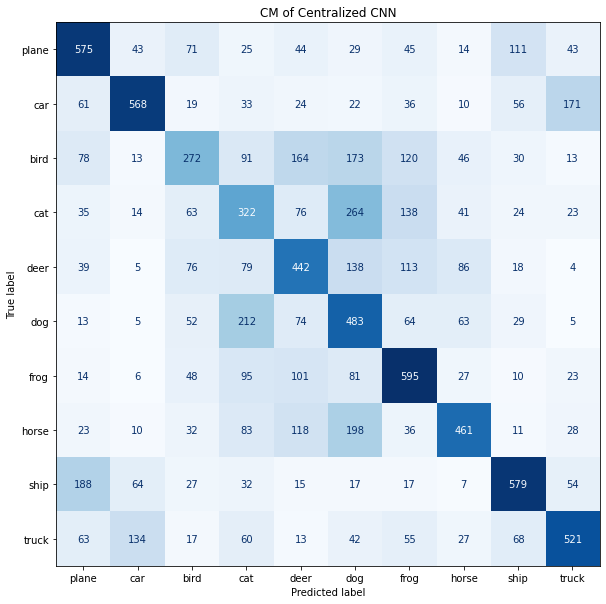

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_test_arr = np.array(y_pred_test_list)
y_true_test_arr = np.array(y_true_test_list)


print('--------------------------------------------------------------------\n'
      'Confusion matrix ...')


# the confusion matrix is normalized over the true conditions (e.g. rows);
cf_matrix = confusion_matrix(y_true=y_true_test_arr,
                             y_pred=y_pred_test_arr)

tn_each = cf_matrix[0][0]
tp_each = cf_matrix[1][1]

class_names = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                 display_labels=class_names)


fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(cmap=plt.cm.Blues,
             colorbar=False,
             ax=ax)


cf_disp.ax_.set_title("CM of Centralized CNN")
plt.show()

## Step 2: Federated Learning with Flower

Step 1 demonstrated a simple centralized training pipeline. All data was in one place (i.e., a single `trainloader` and a single `valloader`). Next, we'll simulate a situation where we have multiple datasets in multiple organizations and where we train a model over these organizations using federated learning.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

In [9]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
def plot_confusion(y_pred_test, y_true_test):
  y_pred_test_list = []
  count = 0
  for a in y_pred_test:
    for b in a:
        y_pred_test_list.append(b.tolist())

  y_true_test_list = []
  for a in y_true_test:
    for b in a:
        y_true_test_list.append(b.tolist())
  
  y_pred_test_arr = np.array(y_pred_test_list)
  y_true_test_arr = np.array(y_true_test_list)


  print('--------------------------------------------------------------------\n'
        'Confusion matrix ...')


  # the confusion matrix is normalized over the true conditions (e.g. rows);
  cf_matrix = confusion_matrix(y_true=y_true_test_arr,
                             y_pred=y_pred_test_arr)

  tn_each = cf_matrix[0][0]
  tp_each = cf_matrix[1][1]

  class_names = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
  )

  cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                 display_labels=class_names)


  fig, ax = plt.subplots(figsize=(10,10))
  cf_disp.plot(cmap=plt.cm.Blues,
             colorbar=False,
             ax=ax)


  cf_disp.ax_.set_title("Confusion Matrix")
  plt.show()

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy, y_pred_test_local, y_true_test_local = test(self.net, self.valloader)
        print("Confusion matrix of local device")
        plot_confusion(y_pred_test_local, y_true_test_local)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [13]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

### Starting the training

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`. 

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

In [14]:
from flwr.server.history import History

In [15]:
def gen_evaluate_fn(
    testloader: DataLoader, device: torch.device
):
    """Generates the function for centralized evaluation.

    Parameters
    ----------
    testloader : DataLoader
        The dataloader to test the model with.
    device : torch.device
        The device to test the model on.

    Returns
    -------
    Callable[ [int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]] ]
        The centralized evaluation function.
    """

    def evaluate(
        server_round: int, parameters_ndarrays, config
    ):
        # pylint: disable=unused-argument
        """Use the entire MNIST test set for evaluation."""
        # determine device
        net = Net()
        params_dict = zip(net.state_dict().keys(), parameters_ndarrays)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        net.load_state_dict(state_dict, strict=True)
        net.to(device)

        loss, accuracy, y_pred_test_cen, y_true_test_cen = test(net, testloader)
        # print(" y_pred_test_cen = ", y_pred_test_cen)
        # print(" y_true_test_cen = ", y_true_test_cen)
        print(" Confusion matrix of server in round ", server_round)
        plot_confusion(y_pred_test_cen, y_true_test_cen)
        # return statistics
        return loss, {"accuracy": accuracy}

    return evaluate

In [16]:
evaluate_fn = gen_evaluate_fn(testloader, DEVICE)

In [17]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

INFO flwr 2023-03-23 10:01:31,799 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-03-23 10:01:37,683	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-23 10:01:41,535 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3965870899.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7931741799.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3965870899.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7931741799.0}
INFO flwr 2023-03-23 10:01:41,540 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-23 10:01:41,561 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO flwr 2023-03-23 10:

 Confusion matrix of server in round  0
--------------------------------------------------------------------
Confusion matrix ...


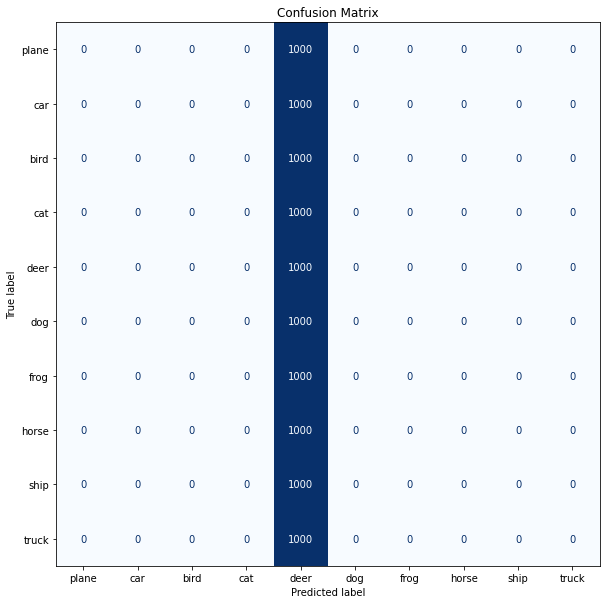

INFO flwr 2023-03-23 10:01:52,330 | server.py:91 | initial parameters (loss, other metrics): 0.07213469405174255, {'accuracy': 0.1}
INFO:flwr:initial parameters (loss, other metrics): 0.07213469405174255, {'accuracy': 0.1}
INFO flwr 2023-03-23 10:01:52,335 | server.py:101 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-03-23 10:01:52,338 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-03-23 10:02:45,708 | server.py:229 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-03-23 10:02:45,770 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


 Confusion matrix of server in round  1
--------------------------------------------------------------------
Confusion matrix ...


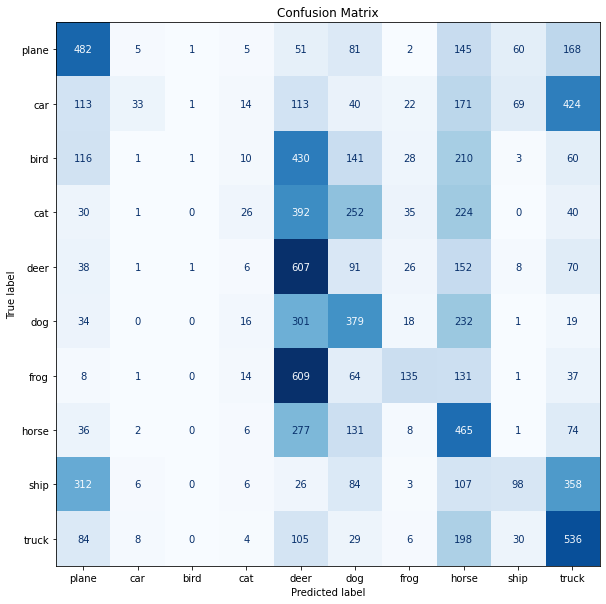

INFO flwr 2023-03-23 10:02:53,462 | server.py:116 | fit progress: (1, 0.06399609260559082, {'accuracy': 0.2762}, 61.12357429899998)
INFO:flwr:fit progress: (1, 0.06399609260559082, {'accuracy': 0.2762}, 61.12357429899998)
DEBUG flwr 2023-03-23 10:02:53,470 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7081) Confusion matrix of local device
(launch_and_evaluate pid=7081) --------------------------------------------------------------------
(launch_and_evaluate pid=7081) Confusion matrix ...
(launch_and_evaluate pid=7082) Figure(1000x1000)
(launch_and_evaluate pid=7081) Figure(1000x1000)
(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7081) Confusion matrix of local device
(launch_and_evaluate pid=7081) --------------------------------------------------------------------
(launch_and_evaluate pid=7081) Confusion matrix ...
(launch_and_evaluate pid=7082) Figure(

DEBUG flwr 2023-03-23 10:03:11,450 | server.py:179 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-03-23 10:03:11,455 | server.py:215 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=7081) Figure(1000x1000)
(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7082) Figure(1000x1000)


(raylet) Spilled 3089 MiB, 41 objects, write throughput 433 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
DEBUG flwr 2023-03-23 10:04:23,036 | server.py:229 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


 Confusion matrix of server in round  2
--------------------------------------------------------------------
Confusion matrix ...


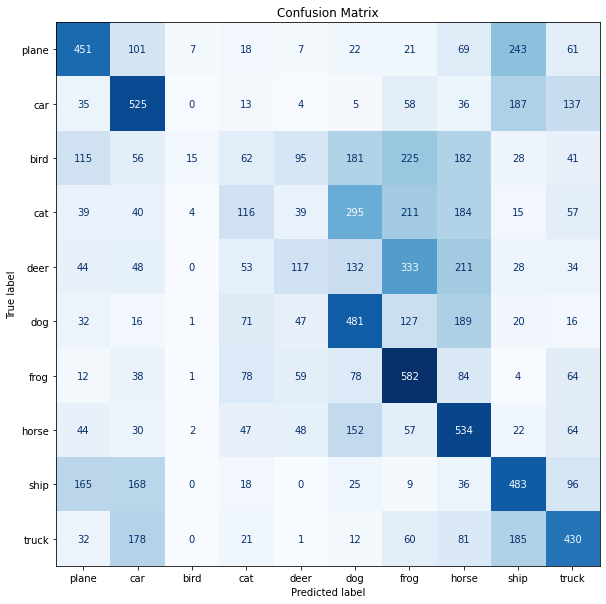

INFO flwr 2023-03-23 10:04:35,172 | server.py:116 | fit progress: (2, 0.053667042899131774, {'accuracy': 0.3734}, 162.834203721)
INFO:flwr:fit progress: (2, 0.053667042899131774, {'accuracy': 0.3734}, 162.834203721)
DEBUG flwr 2023-03-23 10:04:35,178 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7081) Confusion matrix of local device
(launch_and_evaluate pid=7081) --------------------------------------------------------------------
(launch_and_evaluate pid=7081) Confusion matrix ...
(launch_and_evaluate pid=7081) Figure(1000x1000)
(launch_and_evaluate pid=7082) Figure(1000x1000)
(launch_and_evaluate pid=7081) Confusion matrix of local device
(launch_and_evaluate pid=7081) --------------------------------------------------------------------
(launch_and_evaluate pid=7081) Confusion matrix ...
(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7081) Figure(

DEBUG flwr 2023-03-23 10:04:49,620 | server.py:179 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-03-23 10:04:49,623 | server.py:215 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7082) Figure(1000x1000)


(raylet) Spilled 4117 MiB, 48 objects, write throughput 334 MiB/s.
DEBUG flwr 2023-03-23 10:05:42,197 | server.py:229 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


 Confusion matrix of server in round  3
--------------------------------------------------------------------
Confusion matrix ...


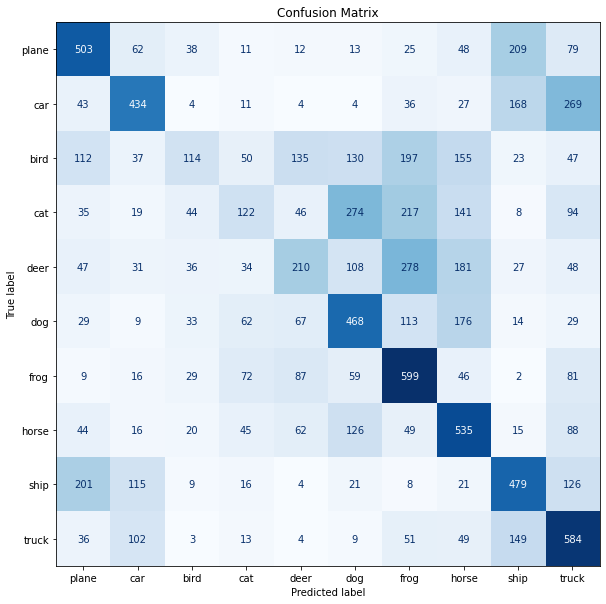

INFO flwr 2023-03-23 10:05:49,929 | server.py:116 | fit progress: (3, 0.05044222192764282, {'accuracy': 0.4048}, 237.59073146800006)
INFO:flwr:fit progress: (3, 0.05044222192764282, {'accuracy': 0.4048}, 237.59073146800006)
DEBUG flwr 2023-03-23 10:05:49,939 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7082) Figure(1000x1000)
(launch_and_evaluate pid=7081) Confusion matrix of local device
(launch_and_evaluate pid=7081) --------------------------------------------------------------------
(launch_and_evaluate pid=7081) Confusion matrix ...
(launch_and_evaluate pid=7081) Figure(1000x1000)
(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7081) Confusion matrix of local device
(launch_and_evaluate pid=7081) --------------------------------------------------------------------
(launch_and_evaluate pid=7081) Confusion matrix ...
(launch_and_evaluate pid=7082) Figure(

DEBUG flwr 2023-03-23 10:06:03,626 | server.py:179 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
INFO flwr 2023-03-23 10:06:03,635 | server.py:144 | FL finished in 251.29673709400004
INFO:flwr:FL finished in 251.29673709400004
INFO flwr 2023-03-23 10:06:03,638 | app.py:202 | app_fit: losses_distributed [(1, 0.0655869505405426), (2, 0.05552618427276611), (3, 0.05259622139930725)]
INFO:flwr:app_fit: losses_distributed [(1, 0.0655869505405426), (2, 0.05552618427276611), (3, 0.05259622139930725)]
INFO flwr 2023-03-23 10:06:03,643 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.272), (2, 0.37039999999999995), (3, 0.384)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 0.272), (2, 0.37039999999999995), (3, 0.384)]}
INFO flwr 2023-03-23 10:06:03,648 | app.py:204 | app_fit: losses_centralized [(0, 0.07213469405174255), (1, 0.06399609260559082), (2, 0.053667042899131774), (3, 0.05044222192764282)]
INF

(launch_and_evaluate pid=7082) Confusion matrix of local device
(launch_and_evaluate pid=7082) --------------------------------------------------------------------
(launch_and_evaluate pid=7082) Confusion matrix ...
(launch_and_evaluate pid=7082) Figure(1000x1000)


In [22]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_fn=evaluate_fn,    
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
)

In [ ]:
print(history)

History (loss, distributed):
	round 1: 0.06356385226249694
	round 2: 0.055753261899948114
	round 3: 0.05212229022979736
History (loss, centralized):
	round 0: 0.07214372310638428
	round 1: 0.0617217071890831
	round 2: 0.05356736168861389
	round 3: 0.05021213753223419
History (metrics, distributed):
{'accuracy': [(1, 0.2844), (2, 0.35200000000000004), (3, 0.3964)]}History (metrics, centralized):
{'accuracy': [(0, 0.1), (1, 0.2951), (2, 0.3768), (3, 0.4114)]}


In [ ]:
print(history.metrics_distributed)

{'accuracy': [(1, 0.2844), (2, 0.35200000000000004), (3, 0.3964)]}


In [ ]:
print(history.losses_distributed)

[(1, 0.06356385226249694), (2, 0.055753261899948114), (3, 0.05212229022979736)]


In [ ]:
print(history.metrics_centralized)

{'accuracy': [(0, 0.1), (1, 0.2951), (2, 0.3768), (3, 0.4114)]}


In [ ]:
print(history.losses_centralized)

[(0, 0.07214372310638428), (1, 0.0617217071890831), (2, 0.05356736168861389), (3, 0.05021213753223419)]


In [ ]:
rounds, acc_cen = zip(*history.metrics_centralized["accuracy"])
print(rounds)
print(acc_cen)

(0, 1, 2, 3)
(0.1, 0.2951, 0.3768, 0.4114)


In [ ]:
rounds_dis, acc_dis = zip(*history.metrics_distributed["accuracy"])
print(rounds_dis)
print(acc_dis)

(1, 2, 3)
(0.2844, 0.35200000000000004, 0.3964)


Text(0, 0.5, 'Accuracy')

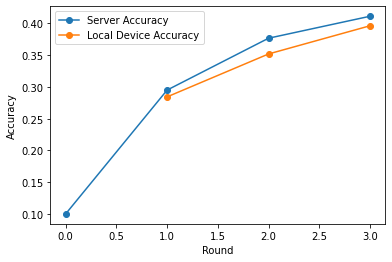

In [ ]:
fig = plt.figure()
plt.plot(np.asarray(rounds), np.asarray(acc_cen), label="Server Accuracy", marker = "o")
plt.plot(np.asarray(rounds_dis), np.asarray(acc_dis), label="Local Device Accuracy", marker = "o")
plt.legend()
plt.xlabel("Round")
plt.ylabel("Accuracy")

In [ ]:
rounds_, loss_cen = zip(*history.losses_centralized)
print(rounds_)
print(loss_cen)

(0, 1, 2, 3)
(0.07214372310638428, 0.0617217071890831, 0.05356736168861389, 0.05021213753223419)


In [ ]:
rounds_dis_, loss_dis = zip(*history.losses_distributed)
print(rounds_dis)
print(loss_dis)

(1, 2, 3)
(0.06356385226249694, 0.055753261899948114, 0.05212229022979736)


Text(0, 0.5, 'Loss')

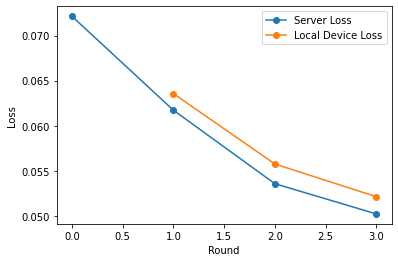

In [ ]:
fig = plt.figure()
plt.plot(np.asarray(rounds_), np.asarray(loss_cen), label="Server Loss", marker = "o")
plt.plot(np.asarray(rounds_dis_), np.asarray(loss_dis), label="Local Device Loss", marker = "o")
plt.legend()
plt.xlabel("Round")
plt.ylabel("Loss")

### How many active clients in each round? And how to select active clients?
In the strategy, the '`configure_fit()`' method is responsible for setting up the training process by specifying the model, the optimizer, the loss function,... Within the '`configure_fit()`' method, we can add code that selects a subset of clients based on our approach.


#### Example:

In [23]:
from flwr.common import (FitIns, Parameters,)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy

Customizing `configure_fit()` from FedAvg:

In [24]:
from flwr.server.strategy import FedAvg

In [18]:
class FedAvg_custom(FedAvg):
  def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.
        Parameters
        ----------
        server_round : int
            The current round of federated learning.
        parameters : Parameters
            The current (global) model parameters.
        client_manager : ClientManager
            The client manager which holds all currently connected clients.

        Returns
        -------
        fit_configuration : List[Tuple[ClientProxy, FitIns]]
            A list of tuples. Each tuple in the list identifies a `ClientProxy` and the
            `FitIns` for this particular `ClientProxy`. If a particular `ClientProxy`
            is not included in this list, it means that this `ClientProxy`
            will not participate in the next round of federated learning.
        """

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Create custom configs
        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"lr": 0.001}
        higher_lr_config = {"lr": 0.003}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, higher_lr_config))
                )
        return fit_configurations


We choose the first half of the active clients to have the learning rate of 0.001, and the second half of it the have the learning rate of 0.003.

##### Notes:
`num_fit_clients()`:
(https://github.com/adap/flower/blob/main/src/py/flwr/server/strategy/fedavg.py)


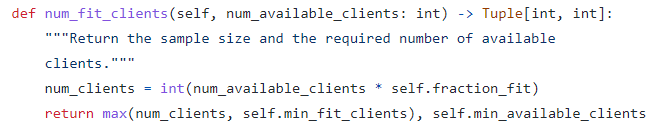

Using our `FedAvg_custom` strategy:

In [19]:
strategy = FedAvg_custom(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_fn=evaluate_fn,    
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

INFO flwr 2023-03-23 04:05:40,547 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-03-23 04:05:47,774	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-23 04:05:49,814 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'object_store_memory': 3982378598.0, 'memory': 7964757198.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'object_store_memory': 3982378598.0, 'memory': 7964757198.0, 'CPU': 2.0}
INFO flwr 2023-03-23 04:05:49,826 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-23 04:05:49,838 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO flwr 2023-03-23 04:

 Confusion matrix of server in round  0
--------------------------------------------------------------------
Confusion matrix ...


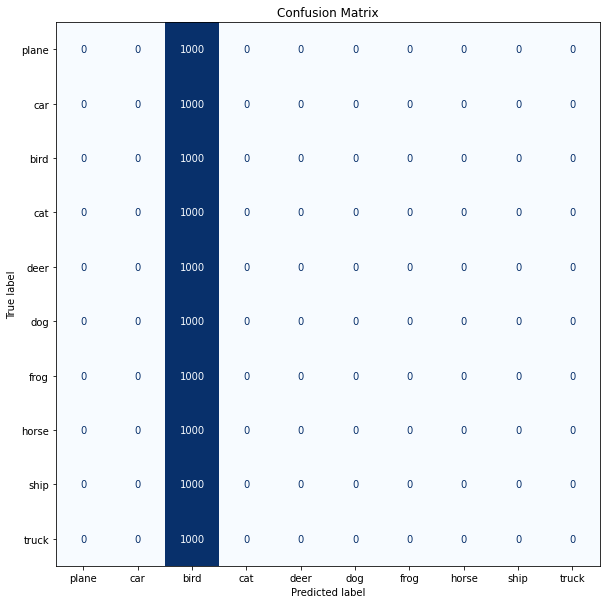

INFO flwr 2023-03-23 04:06:09,019 | server.py:91 | initial parameters (loss, other metrics): 0.07212864272594452, {'accuracy': 0.1}
INFO:flwr:initial parameters (loss, other metrics): 0.07212864272594452, {'accuracy': 0.1}
INFO flwr 2023-03-23 04:06:09,026 | server.py:101 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-03-23 04:06:09,033 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-03-23 04:07:00,574 | server.py:229 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-03-23 04:07:00,607 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


 Confusion matrix of server in round  1
--------------------------------------------------------------------
Confusion matrix ...


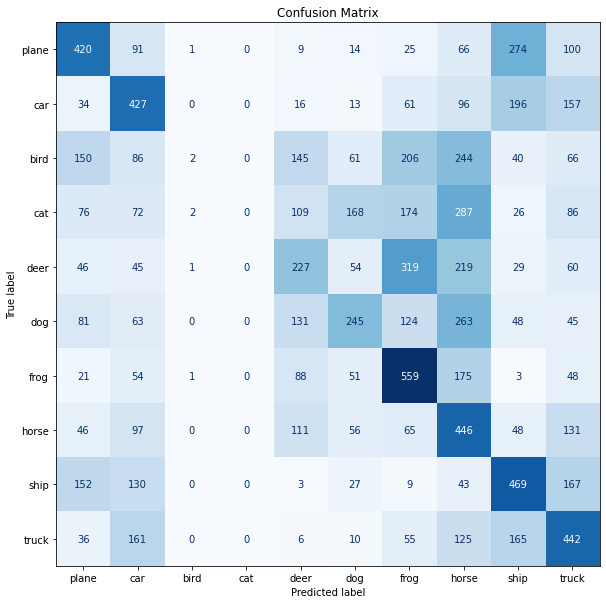

INFO flwr 2023-03-23 04:07:07,602 | server.py:116 | fit progress: (1, 0.06112785456180572, {'accuracy': 0.3237}, 58.56910418699999)
INFO:flwr:fit progress: (1, 0.06112785456180572, {'accuracy': 0.3237}, 58.56910418699999)
DEBUG flwr 2023-03-23 04:07:07,607 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=16168) Confusion matrix of local device
(launch_and_evaluate pid=16168) --------------------------------------------------------------------
(launch_and_evaluate pid=16168) Confusion matrix ...
(launch_and_evaluate pid=16167) Confusion matrix of local device
(launch_and_evaluate pid=16167) --------------------------------------------------------------------
(launch_and_evaluate pid=16167) Confusion matrix ...
(launch_and_evaluate pid=16167) Figure(1000x1000)
(launch_and_evaluate pid=16168) Figure(1000x1000)
(launch_and_evaluate pid=16167) Confusion matrix of local device
(launch_and_evaluate pid=16167) --------------------------------------------------------------------
(launch_and_evaluate pid=16167) Confusion matrix ...
(launch_and_evaluate pid=16168) Confusion matrix of local device
(launch_and_evaluate pid=16168) --------------------------------------------------------------------
(launch_and_evaluate pid=16168) Confusion matrix ...
(launch_and_evaluate pid

DEBUG flwr 2023-03-23 04:07:20,204 | server.py:179 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-03-23 04:07:20,208 | server.py:215 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=16167) Confusion matrix of local device
(launch_and_evaluate pid=16167) --------------------------------------------------------------------
(launch_and_evaluate pid=16167) Confusion matrix ...
(launch_and_evaluate pid=16167) Figure(1000x1000)


(raylet) Spilled 2942 MiB, 39 objects, write throughput 210 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
DEBUG flwr 2023-03-23 04:08:27,835 | server.py:229 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


 Confusion matrix of server in round  2
--------------------------------------------------------------------
Confusion matrix ...


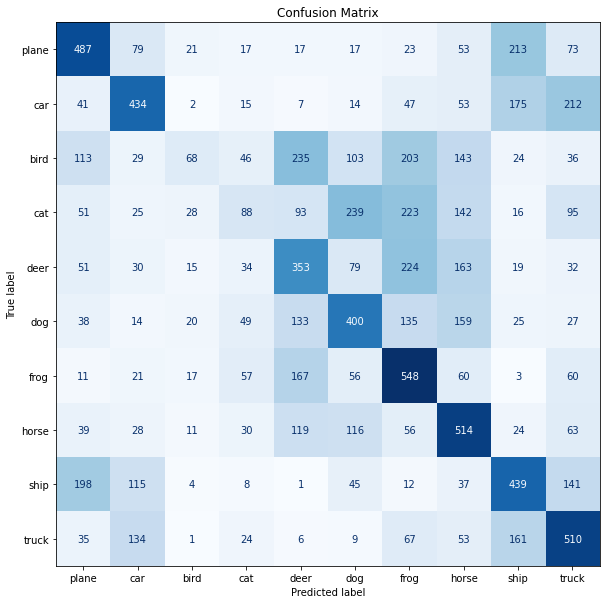

INFO flwr 2023-03-23 04:08:34,248 | server.py:116 | fit progress: (2, 0.052974684786796566, {'accuracy': 0.3841}, 145.21567248500014)
INFO:flwr:fit progress: (2, 0.052974684786796566, {'accuracy': 0.3841}, 145.21567248500014)
DEBUG flwr 2023-03-23 04:08:34,255 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=16167) Confusion matrix of local device
(launch_and_evaluate pid=16167) --------------------------------------------------------------------
(launch_and_evaluate pid=16167) Confusion matrix ...
(launch_and_evaluate pid=16168) Confusion matrix of local device
(launch_and_evaluate pid=16168) --------------------------------------------------------------------
(launch_and_evaluate pid=16168) Confusion matrix ...
(launch_and_evaluate pid=16167) Figure(1000x1000)
(launch_and_evaluate pid=16168) Figure(1000x1000)
(launch_and_evaluate pid=16167) Confusion matrix of local device
(launch_and_evaluate pid=16167) --------------------------------------------------------------------
(launch_and_evaluate pid=16167) Confusion matrix ...
(launch_and_evaluate pid=16168) Confusion matrix of local device
(launch_and_evaluate pid=16168) --------------------------------------------------------------------
(launch_and_evaluate pid=16168) Confusion matrix ...
(launch_and_evaluate pid

DEBUG flwr 2023-03-23 04:08:48,055 | server.py:179 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-03-23 04:08:48,064 | server.py:215 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=16168) Confusion matrix of local device
(launch_and_evaluate pid=16168) --------------------------------------------------------------------
(launch_and_evaluate pid=16168) Confusion matrix ...
(launch_and_evaluate pid=16168) Figure(1000x1000)


(raylet) Spilled 4117 MiB, 49 objects, write throughput 205 MiB/s.
DEBUG flwr 2023-03-23 04:09:42,374 | server.py:229 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


 Confusion matrix of server in round  3
--------------------------------------------------------------------
Confusion matrix ...


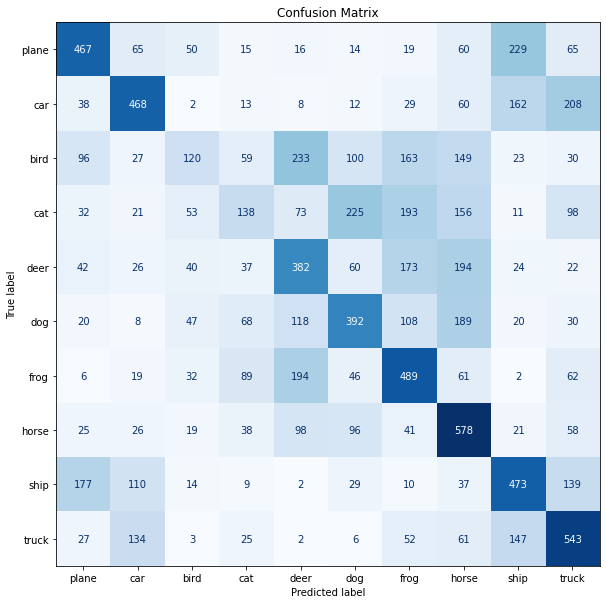

INFO flwr 2023-03-23 04:09:49,891 | server.py:116 | fit progress: (3, 0.05047937548160553, {'accuracy': 0.405}, 220.8583590799999)
INFO:flwr:fit progress: (3, 0.05047937548160553, {'accuracy': 0.405}, 220.8583590799999)
DEBUG flwr 2023-03-23 04:09:49,898 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=16168) Confusion matrix of local device
(launch_and_evaluate pid=16168) --------------------------------------------------------------------
(launch_and_evaluate pid=16168) Confusion matrix ...
(launch_and_evaluate pid=16168) Figure(1000x1000)
(launch_and_evaluate pid=16167) Confusion matrix of local device
(launch_and_evaluate pid=16167) --------------------------------------------------------------------
(launch_and_evaluate pid=16167) Confusion matrix ...
(launch_and_evaluate pid=16167) Figure(1000x1000)
(launch_and_evaluate pid=16168) Confusion matrix of local device
(launch_and_evaluate pid=16168) --------------------------------------------------------------------
(launch_and_evaluate pid=16168) Confusion matrix ...
(launch_and_evaluate pid=16168) Figure(1000x1000)
(launch_and_evaluate pid=16167) Confusion matrix of local device
(launch_and_evaluate pid=16167) --------------------------------------------------------------------
(launch_and_evaluate pid=16

DEBUG flwr 2023-03-23 04:10:03,989 | server.py:179 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
INFO flwr 2023-03-23 04:10:03,996 | server.py:144 | FL finished in 234.96309668899994
INFO:flwr:FL finished in 234.96309668899994
INFO flwr 2023-03-23 04:10:03,998 | app.py:202 | app_fit: losses_distributed [(1, 0.0631680214881897), (2, 0.0545584725856781), (3, 0.05204273929595947)]
INFO:flwr:app_fit: losses_distributed [(1, 0.0631680214881897), (2, 0.0545584725856781), (3, 0.05204273929595947)]
INFO flwr 2023-03-23 04:10:04,001 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.3004), (2, 0.3684), (3, 0.39320000000000005)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 0.3004), (2, 0.3684), (3, 0.39320000000000005)]}
INFO flwr 2023-03-23 04:10:04,003 | app.py:204 | app_fit: losses_centralized [(0, 0.07212864272594452), (1, 0.06112785456180572), (2, 0.052974684786796566), (3, 0.05047937548160553)]
I

(launch_and_evaluate pid=16168) Confusion matrix of local device
(launch_and_evaluate pid=16168) --------------------------------------------------------------------
(launch_and_evaluate pid=16168) Confusion matrix ...
(launch_and_evaluate pid=16168) Figure(1000x1000)

In [ ]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
)

#### Example 2: We choose exactly clients 0, 1, 2, 4 to be active, with different learning rates

In [34]:
class FedAvg_custom2(FedAvg):
  def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.
        Parameters
        ----------
        server_round : int
            The current round of federated learning.
        parameters : Parameters
            The current (global) model parameters.
        client_manager : ClientManager
            The client manager which holds all currently connected clients.

        Returns
        -------
        fit_configuration : List[Tuple[ClientProxy, FitIns]]
            A list of tuples. Each tuple in the list identifies a `ClientProxy` and the
            `FitIns` for this particular `ClientProxy`. If a particular `ClientProxy`
            is not included in this list, it means that this `ClientProxy`
            will not participate in the next round of federated learning.
        """

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        # Create custom configs
        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"lr": 0.001}
        higher_lr_config = {"lr": 0.003}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < 3:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            elif idx == 4:
                fit_configurations.append(
                    (client, FitIns(parameters, higher_lr_config))
                )
        return fit_configurations


In [35]:
strategy = FedAvg_custom2(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_fn=evaluate_fn,    
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

INFO flwr 2023-03-23 10:21:17,467 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-03-23 10:21:23,749	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-23 10:21:25,666 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3971144908.0, 'memory': 7942289819.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3971144908.0, 'memory': 7942289819.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-03-23 10:21:25,678 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-23 10:21:25,688 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO flwr 2023-03-23 10:

 Confusion matrix of server in round  0
--------------------------------------------------------------------
Confusion matrix ...


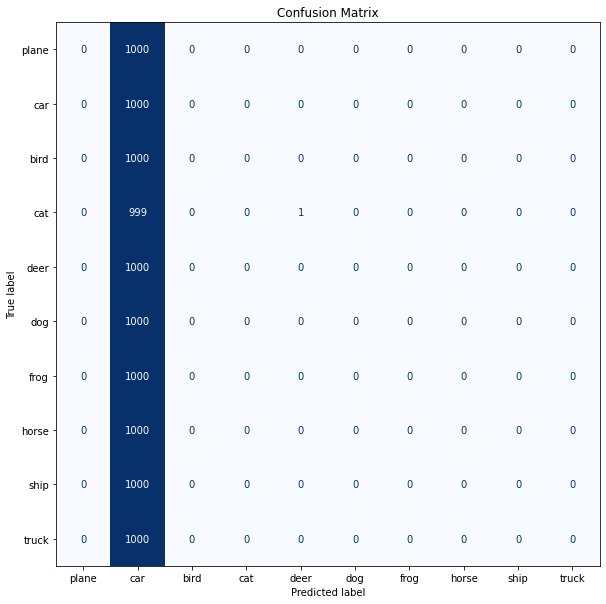

INFO flwr 2023-03-23 10:21:36,685 | server.py:91 | initial parameters (loss, other metrics): 0.07212039935588836, {'accuracy': 0.1}
INFO:flwr:initial parameters (loss, other metrics): 0.07212039935588836, {'accuracy': 0.1}
INFO flwr 2023-03-23 10:21:36,694 | server.py:101 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-03-23 10:21:36,698 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 10)
DEBUG:flwr:fit_round 1: strategy sampled 4 clients (out of 10)


enumerated clients: 


DEBUG flwr 2023-03-23 10:22:00,871 | server.py:229 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-03-23 10:22:00,890 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


 Confusion matrix of server in round  1
--------------------------------------------------------------------
Confusion matrix ...


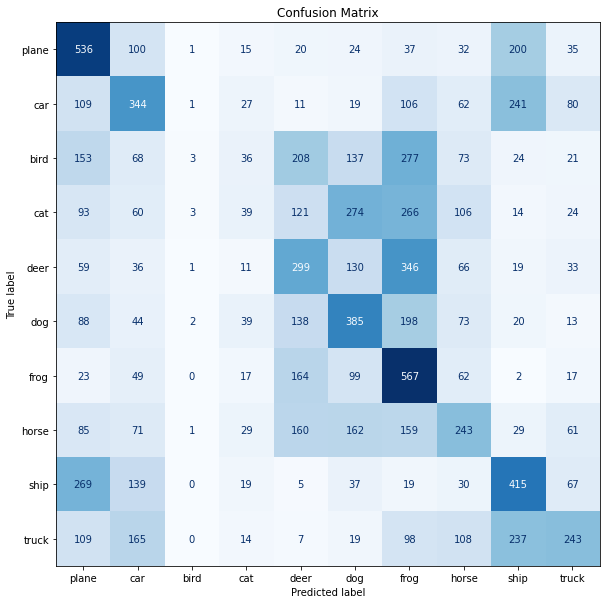

INFO flwr 2023-03-23 10:22:05,956 | server.py:116 | fit progress: (1, 0.05992675058841705, {'accuracy': 0.3074}, 29.258203908999803)
INFO:flwr:fit progress: (1, 0.05992675058841705, {'accuracy': 0.3074}, 29.258203908999803)
DEBUG flwr 2023-03-23 10:22:05,964 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=13719) Confusion matrix of local device
(launch_and_evaluate pid=13719) --------------------------------------------------------------------
(launch_and_evaluate pid=13719) Confusion matrix ...
(launch_and_evaluate pid=13720) Confusion matrix of local device
(launch_and_evaluate pid=13720) --------------------------------------------------------------------
(launch_and_evaluate pid=13720) Confusion matrix ...
(launch_and_evaluate pid=13719) Figure(1000x1000)
(launch_and_evaluate pid=13720) Figure(1000x1000)
(launch_and_evaluate pid=13719) Confusion matrix of local device
(launch_and_evaluate pid=13719) --------------------------------------------------------------------
(launch_and_evaluate pid=13719) Confusion matrix ...
(launch_and_evaluate pid=13720) Confusion matrix of local device
(launch_and_evaluate pid=13720) --------------------------------------------------------------------
(launch_and_evaluate pid=13720) Confusion matrix ...
(launch_and_evaluate pid

DEBUG flwr 2023-03-23 10:22:22,519 | server.py:179 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-03-23 10:22:22,525 | server.py:215 | fit_round 2: strategy sampled 4 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 10)


enumerated clients: 
(launch_and_evaluate pid=13719) Confusion matrix of local device
(launch_and_evaluate pid=13719) --------------------------------------------------------------------
(launch_and_evaluate pid=13719) Confusion matrix ...
(launch_and_evaluate pid=13719) Figure(1000x1000)


DEBUG flwr 2023-03-23 10:22:40,996 | server.py:229 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures


 Confusion matrix of server in round  2
--------------------------------------------------------------------
Confusion matrix ...


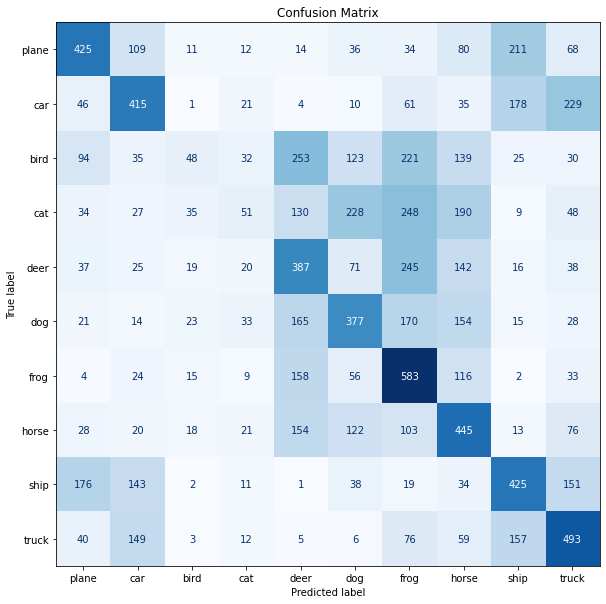

INFO flwr 2023-03-23 10:22:48,210 | server.py:116 | fit progress: (2, 0.053894723403453824, {'accuracy': 0.3649}, 71.51179879499978)
INFO:flwr:fit progress: (2, 0.053894723403453824, {'accuracy': 0.3649}, 71.51179879499978)
DEBUG flwr 2023-03-23 10:22:48,220 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=13720) Confusion matrix of local device
(launch_and_evaluate pid=13720) --------------------------------------------------------------------
(launch_and_evaluate pid=13720) Confusion matrix ...
(launch_and_evaluate pid=13719) Confusion matrix of local device
(launch_and_evaluate pid=13719) --------------------------------------------------------------------
(launch_and_evaluate pid=13719) Confusion matrix ...
(launch_and_evaluate pid=13720) Figure(1000x1000)
(launch_and_evaluate pid=13719) Figure(1000x1000)
(launch_and_evaluate pid=13720) Confusion matrix of local device
(launch_and_evaluate pid=13720) --------------------------------------------------------------------
(launch_and_evaluate pid=13720) Confusion matrix ...
(launch_and_evaluate pid=13720) Figure(1000x1000)
(launch_and_evaluate pid=13719) Confusion matrix of local device
(launch_and_evaluate pid=13719) --------------------------------------------------------------------
(launch_and_evaluate pid=13

DEBUG flwr 2023-03-23 10:22:59,348 | server.py:179 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-03-23 10:22:59,353 | server.py:215 | fit_round 3: strategy sampled 4 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 10)


(launch_and_evaluate pid=13720) Confusion matrix of local device
(launch_and_evaluate pid=13720) --------------------------------------------------------------------
(launch_and_evaluate pid=13720) Confusion matrix ...
enumerated clients: 


DEBUG flwr 2023-03-23 10:23:20,611 | server.py:229 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures


(launch_and_evaluate pid=13720) Figure(1000x1000)
 Confusion matrix of server in round  3
--------------------------------------------------------------------
Confusion matrix ...


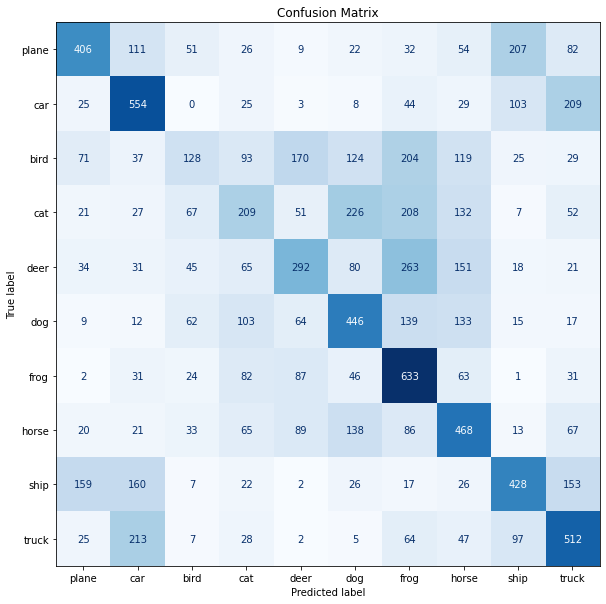

INFO flwr 2023-03-23 10:23:25,803 | server.py:116 | fit progress: (3, 0.05053767138719559, {'accuracy': 0.4076}, 109.10541014199998)
INFO:flwr:fit progress: (3, 0.05053767138719559, {'accuracy': 0.4076}, 109.10541014199998)
DEBUG flwr 2023-03-23 10:23:25,808 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=13719) Confusion matrix of local device
(launch_and_evaluate pid=13719) --------------------------------------------------------------------
(launch_and_evaluate pid=13719) Confusion matrix ...
(launch_and_evaluate pid=13719) Figure(1000x1000)
(launch_and_evaluate pid=13720) Confusion matrix of local device
(launch_and_evaluate pid=13720) --------------------------------------------------------------------
(launch_and_evaluate pid=13720) Confusion matrix ...
(launch_and_evaluate pid=13720) Figure(1000x1000)
(launch_and_evaluate pid=13719) Confusion matrix of local device
(launch_and_evaluate pid=13719) --------------------------------------------------------------------
(launch_and_evaluate pid=13719) Confusion matrix ...
(launch_and_evaluate pid=13719) Figure(1000x1000)
(launch_and_evaluate pid=13720) Confusion matrix of local device
(launch_and_evaluate pid=13720) --------------------------------------------------------------------
(launch_and_evaluate pid=13

DEBUG flwr 2023-03-23 10:23:39,621 | server.py:179 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
INFO flwr 2023-03-23 10:23:39,625 | server.py:144 | FL finished in 122.92721131200005
INFO:flwr:FL finished in 122.92721131200005
INFO flwr 2023-03-23 10:23:39,628 | app.py:202 | app_fit: losses_distributed [(1, 0.06154162497520447), (2, 0.055641493988037104), (3, 0.05323361420631408)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06154162497520447), (2, 0.055641493988037104), (3, 0.05323361420631408)]
INFO flwr 2023-03-23 10:23:39,633 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.2944), (2, 0.3392), (3, 0.386)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 0.2944), (2, 0.3392), (3, 0.386)]}
INFO flwr 2023-03-23 10:23:39,642 | app.py:204 | app_fit: losses_centralized [(0, 0.07212039935588836), (1, 0.05992675058841705), (2, 0.053894723403453824), (3, 0.05053767138719559)]
INFO:flwr:app_fit: loss

(launch_and_evaluate pid=13719) Confusion matrix of local device
(launch_and_evaluate pid=13719) --------------------------------------------------------------------
(launch_and_evaluate pid=13719) Confusion matrix ...
(launch_and_evaluate pid=13720) Figure(1000x1000)
(launch_and_evaluate pid=13719) Figure(1000x1000)


In [36]:
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
)

### How many iterations in local training?

We can customize the number of iterations in local training in `fit()` method of client.

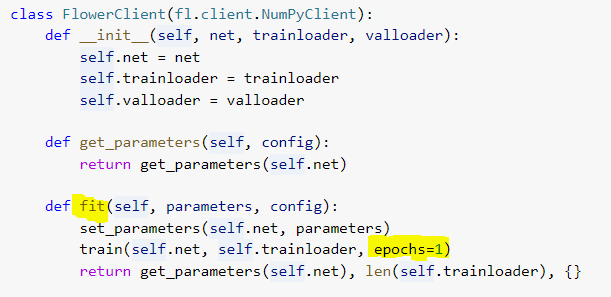

For example, we change `epochs` to `2`.

In [20]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=2)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy, y_pred_test_local, y_true_test_local = test(self.net, self.valloader)
        print("Confusion matrix of local device")
        plot_confusion(y_pred_test_local, y_true_test_local)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [21]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

INFO flwr 2023-03-23 09:45:27,008 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-03-23 09:45:30,809	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-23 09:45:32,907 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'memory': 7933938894.0, 'object_store_memory': 3966969446.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'memory': 7933938894.0, 'object_store_memory': 3966969446.0}
INFO flwr 2023-03-23 09:45:32,923 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-23 09:45:32,932 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO flwr 2023-03-23 09:

 Confusion matrix of server in round  0
--------------------------------------------------------------------
Confusion matrix ...


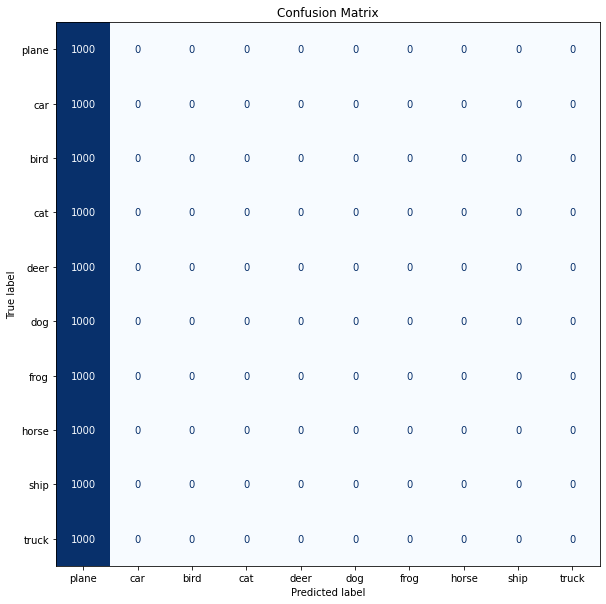

INFO flwr 2023-03-23 09:45:44,530 | server.py:91 | initial parameters (loss, other metrics): 0.07211752107143402, {'accuracy': 0.1}
INFO:flwr:initial parameters (loss, other metrics): 0.07211752107143402, {'accuracy': 0.1}
INFO flwr 2023-03-23 09:45:44,535 | server.py:101 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-03-23 09:45:44,538 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-03-23 09:46:54,036 | server.py:229 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-03-23 09:46:54,070 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


 Confusion matrix of server in round  1
--------------------------------------------------------------------
Confusion matrix ...


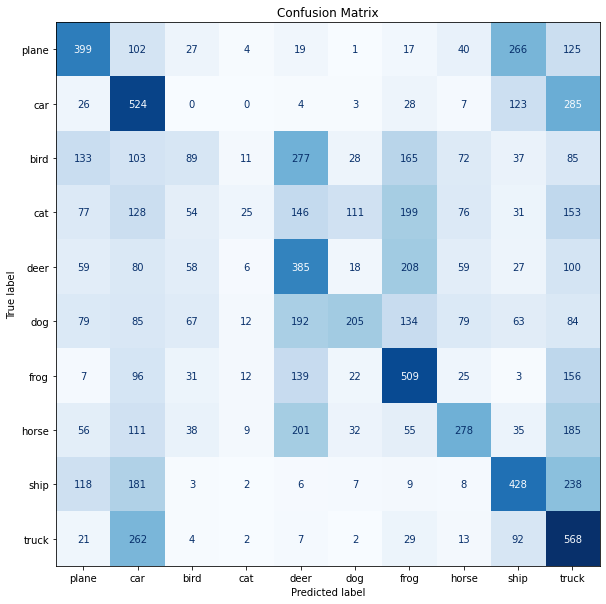

INFO flwr 2023-03-23 09:47:00,315 | server.py:116 | fit progress: (1, 0.06159971127510071, {'accuracy': 0.341}, 75.77707617500005)
INFO:flwr:fit progress: (1, 0.06159971127510071, {'accuracy': 0.341}, 75.77707617500005)
DEBUG flwr 2023-03-23 09:47:00,320 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=1451) Confusion matrix of local device
(launch_and_evaluate pid=1451) --------------------------------------------------------------------
(launch_and_evaluate pid=1451) Confusion matrix ...
(launch_and_evaluate pid=1450) Confusion matrix of local device
(launch_and_evaluate pid=1450) --------------------------------------------------------------------
(launch_and_evaluate pid=1450) Confusion matrix ...
(launch_and_evaluate pid=1451) Figure(1000x1000)
(launch_and_evaluate pid=1450) Figure(1000x1000)
(launch_and_evaluate pid=1450) Confusion matrix of local device
(launch_and_evaluate pid=1450) --------------------------------------------------------------------
(launch_and_evaluate pid=1450) Confusion matrix ...
(launch_and_evaluate pid=1451) Confusion matrix of local device
(launch_and_evaluate pid=1451) --------------------------------------------------------------------
(launch_and_evaluate pid=1451) Confusion matrix ...
(launch_and_evaluate pid=1451) Figure(

DEBUG flwr 2023-03-23 09:47:11,634 | server.py:179 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-03-23 09:47:11,638 | server.py:215 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=1451) Confusion matrix of local device
(launch_and_evaluate pid=1451) --------------------------------------------------------------------
(launch_and_evaluate pid=1451) Confusion matrix ...
(launch_and_evaluate pid=1451) Figure(1000x1000)


(raylet) Spilled 2794 MiB, 36 objects, write throughput 146 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
DEBUG flwr 2023-03-23 09:48:50,558 | server.py:229 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


 Confusion matrix of server in round  2
--------------------------------------------------------------------
Confusion matrix ...


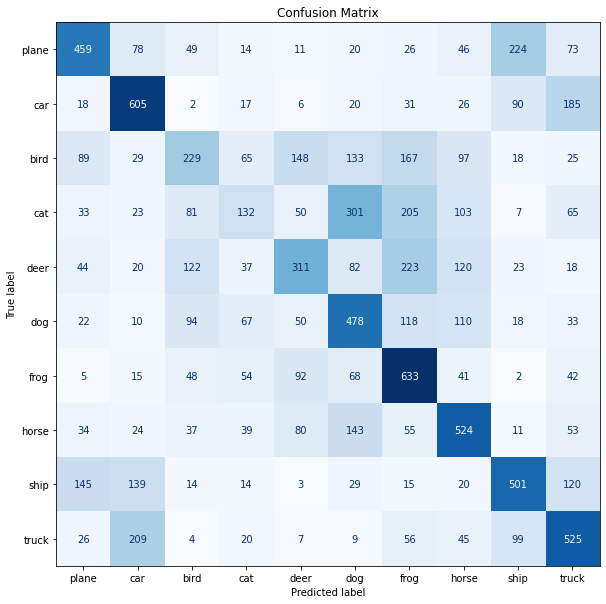

INFO flwr 2023-03-23 09:48:56,856 | server.py:116 | fit progress: (2, 0.048554781889915466, {'accuracy': 0.4397}, 192.31786594200003)
INFO:flwr:fit progress: (2, 0.048554781889915466, {'accuracy': 0.4397}, 192.31786594200003)
DEBUG flwr 2023-03-23 09:48:56,870 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=1450) Confusion matrix of local device
(launch_and_evaluate pid=1450) --------------------------------------------------------------------
(launch_and_evaluate pid=1450) Confusion matrix ...
(launch_and_evaluate pid=1450) Figure(1000x1000)
(launch_and_evaluate pid=1451) Confusion matrix of local device
(launch_and_evaluate pid=1451) --------------------------------------------------------------------
(launch_and_evaluate pid=1451) Confusion matrix ...
(launch_and_evaluate pid=1451) Figure(1000x1000)
(launch_and_evaluate pid=1450) Confusion matrix of local device
(launch_and_evaluate pid=1450) --------------------------------------------------------------------
(launch_and_evaluate pid=1450) Confusion matrix ...
(launch_and_evaluate pid=1450) Figure(1000x1000)
(launch_and_evaluate pid=1451) Confusion matrix of local device
(launch_and_evaluate pid=1451) --------------------------------------------------------------------
(launch_and_evaluate pid=1451) Confusion 

DEBUG flwr 2023-03-23 09:49:17,096 | server.py:179 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-03-23 09:49:17,104 | server.py:215 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=1450) Confusion matrix of local device
(launch_and_evaluate pid=1450) --------------------------------------------------------------------
(launch_and_evaluate pid=1450) Confusion matrix ...
(launch_and_evaluate pid=1450) Figure(1000x1000)


(raylet) Spilled 4117 MiB, 51 objects, write throughput 150 MiB/s.
DEBUG flwr 2023-03-23 09:50:36,394 | server.py:229 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


 Confusion matrix of server in round  3
--------------------------------------------------------------------
Confusion matrix ...


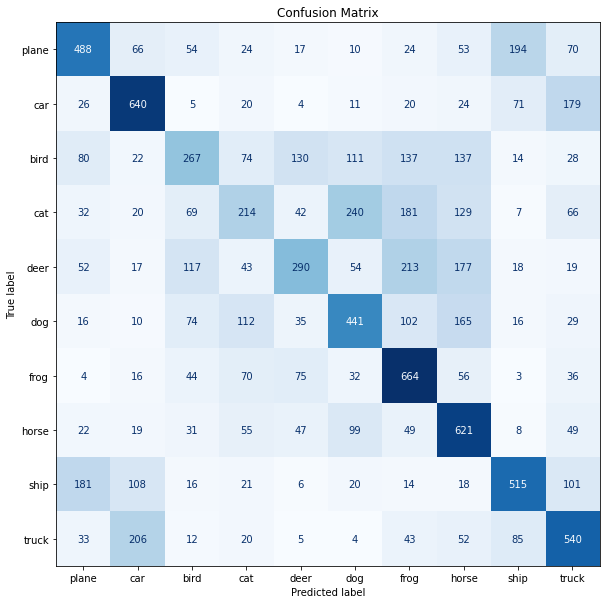

INFO flwr 2023-03-23 09:50:45,793 | server.py:116 | fit progress: (3, 0.045776890313625335, {'accuracy': 0.468}, 301.255313124)
INFO:flwr:fit progress: (3, 0.045776890313625335, {'accuracy': 0.468}, 301.255313124)
DEBUG flwr 2023-03-23 09:50:45,805 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=1451) Confusion matrix of local device
(launch_and_evaluate pid=1451) --------------------------------------------------------------------
(launch_and_evaluate pid=1451) Confusion matrix ...
(launch_and_evaluate pid=1451) Figure(1000x1000)
(launch_and_evaluate pid=1450) Confusion matrix of local device
(launch_and_evaluate pid=1450) --------------------------------------------------------------------
(launch_and_evaluate pid=1450) Confusion matrix ...
(launch_and_evaluate pid=1451) Confusion matrix of local device
(launch_and_evaluate pid=1451) --------------------------------------------------------------------
(launch_and_evaluate pid=1451) Confusion matrix ...
(launch_and_evaluate pid=1450) Figure(1000x1000)
(launch_and_evaluate pid=1451) Figure(1000x1000)
(launch_and_evaluate pid=1450) Confusion matrix of local device
(launch_and_evaluate pid=1450) --------------------------------------------------------------------
(launch_and_evaluate pid=1450) Confusion 

DEBUG flwr 2023-03-23 09:51:08,305 | server.py:179 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
INFO flwr 2023-03-23 09:51:08,318 | server.py:144 | FL finished in 323.78042199099997
INFO:flwr:FL finished in 323.78042199099997
INFO flwr 2023-03-23 09:51:08,328 | app.py:202 | app_fit: losses_distributed [(1, 0.06327210321426392), (2, 0.05061619601249695), (3, 0.047860721063613894)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06327210321426392), (2, 0.05061619601249695), (3, 0.047860721063613894)]
INFO flwr 2023-03-23 09:51:08,350 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.3236), (2, 0.42679999999999996), (3, 0.458)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 0.3236), (2, 0.42679999999999996), (3, 0.458)]}
INFO flwr 2023-03-23 09:51:08,353 | app.py:204 | app_fit: losses_centralized [(0, 0.07211752107143402), (1, 0.06159971127510071), (2, 0.048554781889915466), (3, 0.04577689031362533

(launch_and_evaluate pid=1450) Figure(1000x1000)
(launch_and_evaluate pid=1451) Confusion matrix of local device
(launch_and_evaluate pid=1451) --------------------------------------------------------------------
(launch_and_evaluate pid=1451) Confusion matrix ...
(launch_and_evaluate pid=1451) Figure(1000x1000)


In [23]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
)